In [2]:
!pip install faker


In [3]:
import pandas as pd
import numpy as np
import random
from faker import Faker

fake = Faker()
np.random.seed(42)

# ICD-10 and CPT code samples
icd_codes = ['I10', 'E11.9', 'M54.5', 'J45.909', 'K21.9']
cpt_codes = {
    '99213': 'Office visit',
    '93000': 'Electrocardiogram',
    '80050': 'General health panel',
    '90658': 'Flu vaccine',
    '36415': 'Blood draw',
}

n_samples = 1000
fraud_ratio = 0.1

data = []
for i in range(n_samples):
    patient_id = fake.uuid4()
    visit_date = fake.date_between(start_date='-1y', end_date='today')
    diagnosis = random.choice(icd_codes)
    procedure_code = random.choice(list(cpt_codes.keys()))
    procedure_desc = cpt_codes[procedure_code]

    standard_cost = round(np.random.uniform(50, 500), 2)
    is_fraud = np.random.rand() < fraud_ratio

    if is_fraud:
        fraud_type = np.random.choice(['upcoding', 'phantom', 'duplicate', 'unbundling'])
        if fraud_type == 'upcoding':
            cost = round(standard_cost * np.random.uniform(1.5, 3.0), 2)
        elif fraud_type == 'phantom':
            procedure_code = '99999'
            procedure_desc = 'Phantom procedure'
            cost = round(np.random.uniform(100, 500), 2)
        elif fraud_type == 'duplicate':
            cost = standard_cost
        elif fraud_type == 'unbundling':
            cost = round(standard_cost + np.random.uniform(20, 100), 2)
    else:
        cost = standard_cost

    data.append({
        'PatientID': patient_id,
        'VisitDate': visit_date,
        'DiagnosisCode': diagnosis,
        'ProcedureCode': procedure_code,
        'ProcedureDescription': procedure_desc,
        'StandardCost': standard_cost,
        'ProcedureCost': cost,
        'Label': int(is_fraud)
    })

df = pd.DataFrame(data)
df.head()


,PatientID,VisitDate,DiagnosisCode,ProcedureCode,ProcedureDescription,StandardCost,ProcedureCost,Label
0,ec449cad-6947-44d7-9c21-39d9a6b164af,2024-06-28,M54.5,80050,General health panel,218.54,218.54,0
1,297cedde-dda1-4316-9670-45736810ccfa,2025-01-03,I10,93000,Electrocardiogram,379.40,379.40,0
2,f615897d-82cf-4cf7-b317-b9684d4ed973,2024-08-28,M54.5,93000,Electrocardiogram,120.21,120.21,0
3,8269253f-8d3b-41c7-b2b9-e49f9b3e7c4c,2025-01-02,K21.9,90658,Flu vaccine,76.14,76.14,0
4,112ea25b-7b0e-4d2f-858b-d851c000c5b9,2024-06-05,K21.9,99213,Office visit,320.50,320.50,0


In [4]:
# Feature: Overbilling rate
df['OverbillingRate'] = (df['ProcedureCost'] - df['StandardCost']) / df['StandardCost']

# Feature: Code validity (e.g., Phantom billing)
df['InvalidCode'] = df['ProcedureCode'].apply(lambda x: 1 if x == '99999' else 0)

# Duplicate flag: same patient, date, and procedure
df['DuplicateFlag'] = df.duplicated(subset=['PatientID', 'VisitDate', 'ProcedureCode'], keep=False).astype(int)

# High-cost flag
df['HighCostFlag'] = df['ProcedureCost'] > 1000

# Final feature set
features = ['OverbillingRate', 'InvalidCode', 'DuplicateFlag', 'HighCostFlag']
X = df[features]
y = df['Label']

df[features + ['Label']].head()


,OverbillingRate,InvalidCode,DuplicateFlag,HighCostFlag,Label
0,0.0,0,0,False,0
1,0.0,0,0,False,0
2,0.0,0,0,False,0
3,0.0,0,0,False,0
4,0.0,0,0,False,0


In [5]:
!pip install xgboost scikit-learn


In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:49:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[180   0]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       180
           1       1.00      0.75      0.86        20

    accuracy                           0.97       200
   macro avg       0.99      0.88      0.92       200
weighted avg       0.98      0.97      0.97       200



In [7]:
!pip install shap


In [8]:
print(X_train.dtypes)



OverbillingRate    float64
InvalidCode          int64
DuplicateFlag        int64
HighCostFlag          bool
dtype: object


In [9]:
features = ['OverbillingRate', 'InvalidCode', 'DuplicateFlag', 'HighCostFlag']


In [10]:
X = df[features].copy()

# Just to be safe, convert all to float:
X = X.astype(float)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:49:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


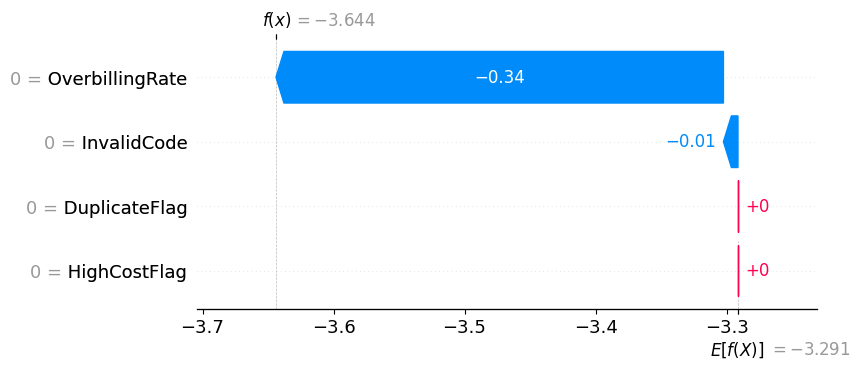

In [12]:
# Prepare features - convert to numeric explicitly
X = df[features].copy()
X = X.astype(float)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# SHAP Explainer
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0])


In [13]:
!pip install streamlit pyngrok --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00


In [14]:
# Replace with your actual authtoken from ngrok
!ngrok authtoken 2x84Q8TsYxwwoZfQ56i5qQDBAKE_3Gur3Fz6SUaYbARdBKNuE


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [15]:
%%writefile app.py
import streamlit as st
import pandas as pd

st.set_page_config(page_title="MedBill Shield", page_icon="🏥")

st.title("🏥 MedBill Shield – Hospital Billing Fraud Detector")

uploaded_file = st.file_uploader("📄 Upload a Hospital Billing CSV", type="csv")

if uploaded_file:
    df = pd.read_csv(uploaded_file)

    st.subheader("🔍 Uploaded Billing Data")
    st.dataframe(df)

    # Add simple fraud detection features
    df['Overbilling'] = df['ProcedureCost'] > df['StandardCost']
    df['DuplicateFlag'] = df.duplicated(subset=['PatientID', 'VisitDate', 'ProcedureCode'], keep=False)
    df['HighCost'] = df['ProcedureCost'] > 1000
    df['FraudRisk'] = df[['Overbilling', 'DuplicateFlag', 'HighCost']].any(axis=1)

    st.subheader("🚨 Flagged Risky Claims")
    st.dataframe(df[df['FraudRisk'] == True])


Writing app.py


In [16]:
# ✅ Step 1: Install dependencies
!pip install -q streamlit pyngrok
!pkill streamlit

# ✅ Step 2: Add your ngrok v3 authtoken (replace with your actual one)
!ngrok config add-authtoken 2x84Q8TsYxwwoZfQ56i5qQDBAKE_3Gur3Fz6SUaYbARdBKNuE




Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [17]:
import time
from pyngrok import ngrok

In [18]:
# ✅ Step 3: Define Streamlit app (or load your existing one)
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import pandas as pd

st.set_page_config(page_title="MedBill Shield")
st.title("🏥 MedBill Shield – Hospital Billing Fraud Detection")

uploaded_file = st.file_uploader("📤 Upload Hospital Billing CSV", type="csv")

if uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.subheader("📋 Uploaded Data")
    st.dataframe(df)

    st.subheader("🔍 Suspicious Entries Detected")

    df['Overbilled'] = df['ProcedureCost'] > df['StandardCost']
    df['Duplicate'] = df.duplicated(['PatientID', 'ProcedureCode', 'VisitDate'], keep=False)
    df['HighCost'] = df['ProcedureCost'] > 1000

    flagged = df[df[['Overbilled', 'Duplicate', 'HighCost']].any(axis=1)]
    st.write(flagged)
""")


In [19]:
# Start Streamlit
!streamlit run app.py &> /dev/null &  # runs in background silently


# Add a longer wait to ensure Streamlit is running
import time
time.sleep(15)

In [20]:

# Then launch ngrok
from pyngrok import ngrok
public_url = ngrok.connect(addr="8501", proto="http")
print(f"🔗 Your app is live at: {public_url}")


🔗 Your app is live at: NgrokTunnel: "https://dcbd-34-143-194-33.ngrok-free.app" -> "http://localhost:8501"
